In [239]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
import random
from preproc import *
from itertools import combinations
from scipy.special import factorial
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import textwrap
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, ClassifierMixin



In [240]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [241]:
good_cell_labels = list()
with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
print(good_cell_labels)

['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch19c2', '20181102ch26c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181102ch45c1', '20181102ch45c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c1', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181101ch45c1', '20181031ch19c1', '20181031ch19c2', '20181031ch19c3', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch30c2', '20181031ch35c1', '20181031ch35c2', '20181031ch35c3', '20181031ch43c1', '20181031ch43c2', '20181031ch45c1', '20181031ch45c2', '20181026ch19c1', '20181026ch19c2', '20181026ch19c3', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch35c3', '20181026c

In [504]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True
# Save Figures
to_save = True
figsave_dir = 'figures/population_prob_distribution'

In [243]:
#Read placeist files
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])

In [525]:
# Set amount of bins, see which cells are valid for testing 
total_bins = 21
two_thirds = 20
valid_dist_size = 2
valid_cells_distribution = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        total_valid_bins = list()
        # if 2/3 of the bins contain over 30 samples, the cell is valid
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if dist.size > valid_dist_size:
                total_valid_bins.append(bin)

        if len(total_valid_bins) > two_thirds:
            valid_cells_distribution.append(label)
            
print('Amount of valid cells:', len(valid_cells_distribution))
train_size = int(round((len(valid_cells_distribution) * 0.7),0))
test_size = int(round((len(valid_cells_distribution) * 0.3),0))
print(train_size)
print(test_size)
print(valid_cells_distribution)
list_nums = list(range(1,(len(valid_cells_distribution) + 1)))
valid_cell_to_num = dict(zip(valid_cells_distribution, list_nums))

print(valid_cell_to_num)
new_day_list = list()

for cell in valid_cells_distribution:
    new_day = cell[:8]
    new_day_list.append(new_day)


Amount of valid cells: 276
193
83
['20181105ch29c1', '20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181101ch19c1', '20181101ch21c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch43c1', '20181031ch19c2', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c2', '20181022ch43c4', '20181022ch45c1', '20181022ch93c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch6c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch29c1', '20181011ch45c1', '20181011ch45c2', '20181011ch45c3', '20181010ch45

In [526]:
bins_data = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data:
                bins_data[bin] = []
            bins_data[bin].append(dist)


In [527]:
# normalized to the sum 
for key, distributions in bins_data.items():
    for i in range(len(distributions)):
        distribution = distributions[i]
        total = sum(distribution)
        distributions[i] = [float(i) / total for i in distribution]

In [537]:
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        for i in range(num_sess_cells):
            cell_label = data['cell_labels'][i]
            if cell_label in valid_cells_distribution:
                all_place_responses.append(data['place_responses_per_cell'][i])
                all_place_durations.append(data['durations_per_place'])
                all_cell_labels.append(cell_label)

num_all_cells = len(all_cell_labels)
print(all_cell_labels)

['20181105ch29c1', '20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181101ch19c1', '20181101ch21c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch43c1', '20181031ch19c2', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c2', '20181022ch43c4', '20181022ch45c1', '20181022ch93c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch6c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch29c1', '20181011ch45c1', '20181011ch45c2', '20181011ch45c3', '20181010ch45c1', '20181009ch45c1', '20181009ch

In [529]:
for cell, place_responses_per_cell in enumerate(all_place_responses):
    print(cell)
    num_bins = 25
    response_params_per_cell = np.zeros((num_bins+1, 3))
    place_durations_per_cell = all_place_durations[cell]
    for bin, dist in place_responses_per_cell.items():
        total = sum(dist)
        dist= [float(i) / total for i in dist]
        response_params_per_cell[bin,0] = np.mean(dist)
        response_params_per_cell[bin,1] = np.std(dist, ddof=1)
        response_params_per_cell[bin,2] = np.sum(place_durations_per_cell[bin])
    response_params_per_cell[:,2] = response_params_per_cell[:,2] / np.sum(response_params_per_cell[:,2])
    all_place_responses[cell] = response_params_per_cell
all_place_responses = np.array(all_place_responses)

# Clean up large memory variables
del all_place_durations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [515]:
from scipy.stats import lognorm
from scipy.stats import expon
from collections import Counter

class BayesDecoder:
    def __init__(self, dist):
        self.dist = dist
        self.num_cells = dist.shape[0]
        self.num_bins = dist.shape[1]
        
    def gaussian_pdf(x, mu, sig):
        return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
    
    def __likelihood(self, x, cell, bin):
        mu, sig = self.dist[cell,bin,0], self.dist[cell,bin,1]
        return BayesDecoder.gaussian_pdf(x, mu, sig)
    
    def __predict_cell(self, x, cell):
        posterior = np.zeros(self.num_bins)
        for bin in range(1, self.num_bins):
            prior = self.dist[cell,bin,2]
            posterior[bin] = prior * self.__likelihood(x, cell, bin)
        posterior = np.nan_to_num(posterior, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        pred = np.argmax(posterior[1:])
        return pred, posterior[pred] 

    def predict(self, x):
        prediction, confidence = np.zeros(self.num_cells), np.zeros(self.num_cells)
        for cell in range(self.num_cells):
            pred, conf = self.__predict_cell(x[cell], cell)
            prediction[cell] = pred
            confidence[cell] = conf
        unique_preds, counts = np.unique(prediction, return_counts=True)
        #return lines
        most_common_pred = unique_preds[np.argmax(counts)]
        counts = Counter(prediction)
        most_common = counts.most_common(5)
        total_count = len(prediction)
        unique_proportions = {int(unique + 1): f'{round((count / total_count) * 100, 2)}%' for unique, count in counts.items()}
        cleaned_proportions = {k: float(v.strip('%')) for k, v in unique_proportions.items()}

        top_three_bins = [num + 1 for num, _ in most_common]

        return cleaned_proportions 
    

In [524]:
place_decoder = BayesDecoder(all_place_responses)
print(len(valid_cells_distribution))

212


In [517]:
# Refresh averages
from collections import defaultdict

cumulative_sums = defaultdict(lambda: defaultdict(float))
counts = defaultdict(lambda: defaultdict(int))

num_runs = 0

In [518]:
def update_running_average(new_run):
    for bin_num, percentages in new_run.items():
        for b, percentage in percentages.items():
            cumulative_sums[bin_num][b] += percentage
            counts[bin_num][b] += 1

In [519]:
num_iterations = 80
for _ in range(num_iterations):
    random_values = {}
    
    for key, distributions in bins_data.items():
        key_random_values = [random.choice(distribution) for distribution in distributions]
        random_values[key] = key_random_values
    
    predictions = {}
    for key in bins_data.keys():
        bin_prediction_list = random_values[key]
        predicted_bin = place_decoder.predict(bin_prediction_list)
        sorted_percentages = dict(sorted(predicted_bin.items(), key=lambda item: item[1], reverse=True))
        predictions[key] = sorted_percentages
    
    update_running_average(predictions)
    num_runs += 1
    print('Number of Samples:', num_runs)


/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))


Number of Samples: 1
Number of Samples: 2
Number of Samples: 3
Number of Samples: 4
Number of Samples: 5
Number of Samples: 6
Number of Samples: 7
Number of Samples: 8
Number of Samples: 9
Number of Samples: 10
Number of Samples: 11
Number of Samples: 12
Number of Samples: 13
Number of Samples: 14
Number of Samples: 15
Number of Samples: 16
Number of Samples: 17
Number of Samples: 18
Number of Samples: 19
Number of Samples: 20
Number of Samples: 21
Number of Samples: 22
Number of Samples: 23
Number of Samples: 24
Number of Samples: 25
Number of Samples: 26
Number of Samples: 27
Number of Samples: 28
Number of Samples: 29
Number of Samples: 30
Number of Samples: 31
Number of Samples: 32
Number of Samples: 33
Number of Samples: 34
Number of Samples: 35
Number of Samples: 36
Number of Samples: 37
Number of Samples: 38
Number of Samples: 39
Number of Samples: 40
Number of Samples: 41
Number of Samples: 42
Number of Samples: 43
Number of Samples: 44
Number of Samples: 45
Number of Samples: 

In [520]:
averages = defaultdict(dict)
for bin_num, sum_dict in cumulative_sums.items():
    for b, total_sum in sum_dict.items():
        averages[bin_num][b] = total_sum / counts[bin_num][b]

print("Averages of percentages across all runs:")
for bin_num, avg_dict in sorted(averages.items()):
    print(f"Bin {bin_num}:")
    for b, avg in sorted(avg_dict.items()):
        print(f"  Bin {b}: {avg:.2f}%")

Averages of percentages across all runs:
Bin 1:
  Bin 1: 18.25%
  Bin 2: 4.55%
  Bin 3: 0.90%
  Bin 4: 2.77%
  Bin 5: 9.76%
  Bin 6: 0.98%
  Bin 8: 0.83%
  Bin 10: 3.39%
  Bin 11: 1.40%
  Bin 12: 1.00%
  Bin 13: 0.64%
  Bin 14: 0.85%
  Bin 15: 1.95%
  Bin 16: 10.62%
  Bin 18: 0.73%
  Bin 20: 0.74%
  Bin 21: 11.75%
  Bin 22: 5.15%
  Bin 23: 0.92%
  Bin 24: 6.14%
  Bin 25: 18.84%
Bin 2:
  Bin 1: 1.75%
  Bin 2: 7.65%
  Bin 3: 2.41%
  Bin 4: 1.63%
  Bin 5: 0.65%
  Bin 6: 0.76%
  Bin 8: 3.51%
  Bin 10: 3.62%
  Bin 11: 5.84%
  Bin 12: 8.40%
  Bin 13: 12.32%
  Bin 14: 8.99%
  Bin 15: 8.86%
  Bin 16: 10.02%
  Bin 18: 4.01%
  Bin 20: 0.67%
  Bin 21: 0.65%
  Bin 22: 2.04%
  Bin 23: 2.02%
  Bin 24: 11.80%
  Bin 25: 3.50%
Bin 3:
  Bin 1: 1.44%
  Bin 2: 7.23%
  Bin 3: 1.94%
  Bin 4: 1.33%
  Bin 5: 0.61%
  Bin 6: 0.94%
  Bin 8: 3.67%
  Bin 10: 3.64%
  Bin 11: 6.08%
  Bin 12: 9.69%
  Bin 13: 14.40%
  Bin 14: 10.27%
  Bin 15: 9.69%
  Bin 16: 7.83%
  Bin 18: 4.33%
  Bin 20: 0.59%
  Bin 21: 0.64%
  Bin 

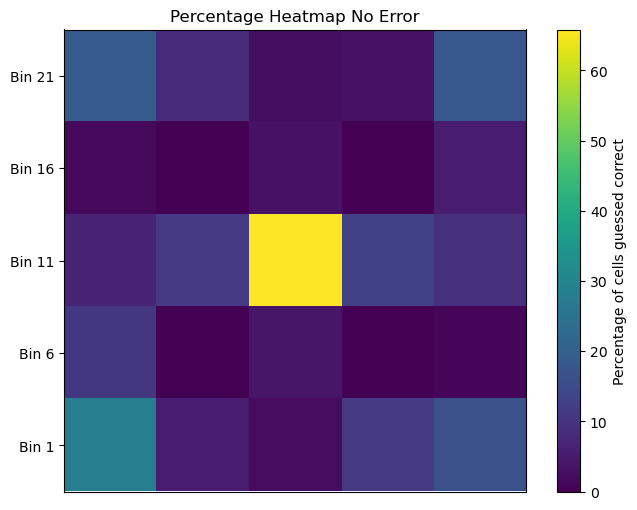

In [505]:
matrix = np.zeros((5, 5))
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = percentages.get(bin_num, 0)
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=np.max(matrix))
plt.colorbar(label='Percentage of cells guessed correct')
plt.xticks(ticks=np.arange(0), labels=[])
plt.yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
plt.title('Percentage Heatmap No Error')
if to_save:
    if not os.path.exists(figsave_dir):
        os.makedirs(figsave_dir)
    plt.savefig(f'{figsave_dir}/prob_distribution_no_error.png', bbox_inches='tight')
plt.show()

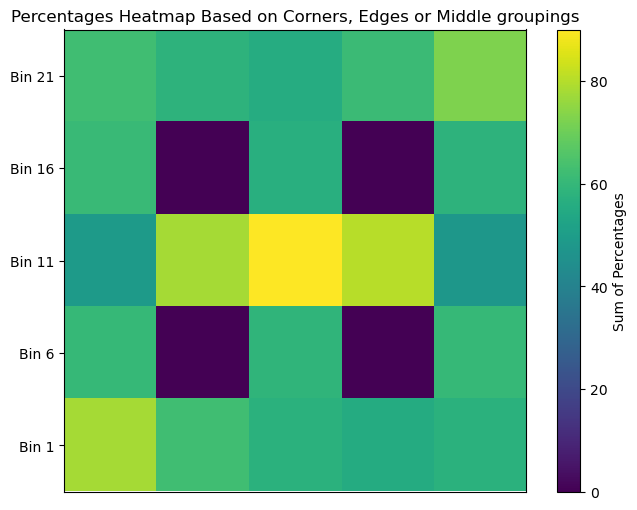

In [506]:
matrix = np.zeros((5, 5))
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

grouping_corners = [1,5,21,25]
grouping_edges = [2,3,4,6,11,16,22,23,24,10,15,20]
grouping_middle = [12,13,14,8,18]

bin_sums = {bin_num: 0 for bin_num in bins}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        percentage_value = percentages.get(bin_num, 0)
        if bin_num in grouping_corners:
            for b in grouping_corners:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_edges:
            for b in grouping_edges:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_middle:
            for b in grouping_middle:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]

for bin_num, total_percentage in bin_sums.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = total_percentage

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Sum of Percentages')
plt.xticks(ticks=np.arange(0), labels=[])
plt.yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
plt.title('Percentages Heatmap Based on Corners, Edges or Middle groupings')
plt.show()

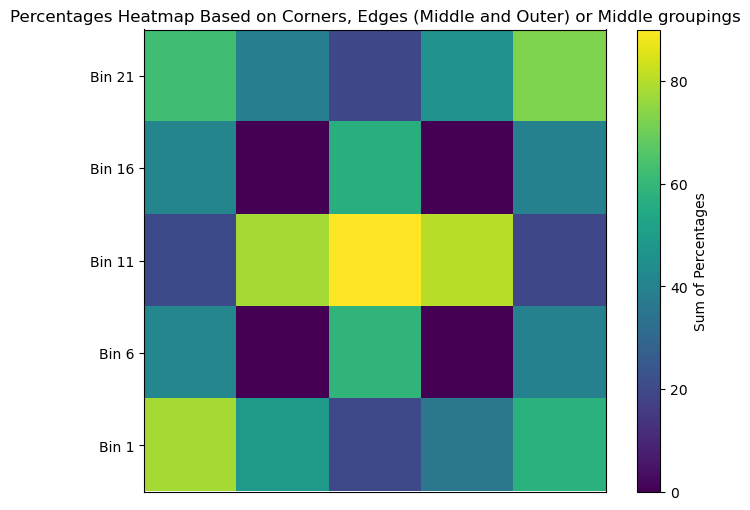

In [507]:
matrix = np.zeros((5, 5))
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
bin_to_index = {bin_num: idx for idx, bin_num in enumerate(bins)}

grouping_corners = [1,5,21,25]
grouping_mid_edges = [3,11,23,15]
grouping_middle = [12,13,14,8,18]
grouping_outer_edges = [22,24,6,16,2,4,10,20]
bin_sums = {bin_num: 0 for bin_num in bins}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        if bin_num in grouping_corners:
            for b in grouping_corners:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_mid_edges:
            for b in grouping_mid_edges:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_middle:
            for b in grouping_middle:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
        elif bin_num in grouping_outer_edges:
            for b in grouping_outer_edges:
                if b in percentages:
                    bin_sums[bin_num] += percentages[b]
                    
for bin_num, total_percentage in bin_sums.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = total_percentage

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Sum of Percentages')
plt.xticks(ticks=np.arange(0), labels=[])
plt.yticks(ticks=np.arange(5), labels=['Bin 21','Bin 16', 'Bin 11', 'Bin 6','Bin 1'])
plt.title('Percentages Heatmap Based on Corners, Edges (Middle and Outer) or Middle groupings')
if to_save:
    if not os.path.exists(figsave_dir):
        os.makedirs(figsave_dir)
    plt.savefig(f'{figsave_dir}/prob_distribution_groupings.png', bbox_inches='tight')
plt.show()

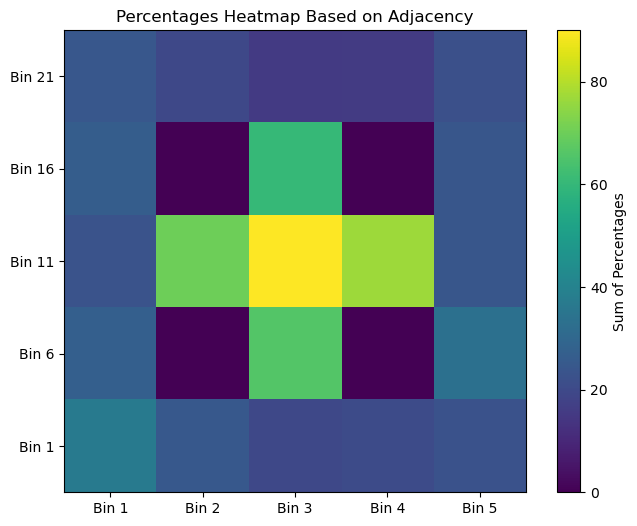

In [509]:
def to_coords(index):
    return index // 5, index % 5

def to_index(row, col):
    return row * 5 + col

def get_neighbors(bin_num):
    if bin_num not in bin_to_index:
        return []
    
    row, col = to_coords(bin_to_index[bin_num])
    neighbors = []
    
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < 5 and 0 <= new_col < 5:
                neighbor_index = to_index(new_row, new_col)
                if neighbor_index in bin_to_index.values():
                    neighbors.append(bins[neighbor_index])
    
    return neighbors

bin_sums = {bin_num: 0 for bin_num in bins}

for bin_num, percentages in averages.items():
    if bin_num in bin_to_index:
        neighbors = get_neighbors(bin_num)
        
        total_percentage = 0
        for neighbor in neighbors:
            if neighbor in percentages:
                total_percentage += percentages[neighbor]
        if bin_num in percentages:
            total_percentage += percentages[bin_num]
        bin_sums[bin_num] = total_percentage

for bin_num, total_percentage in bin_sums.items():
    if bin_num in bin_to_index:
        row_idx = bin_to_index[bin_num] // 5
        col_idx = bin_to_index[bin_num] % 5
        if bin_num in [7, 9, 17, 19]:
            matrix[row_idx, col_idx] = 0
        else:
            matrix[row_idx, col_idx] = total_percentage

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Sum of Percentages')
plt.xticks(ticks=np.arange(5), labels=[f'Bin {i}' for i in range(1, 6)])
plt.yticks(ticks=np.arange(5), labels=[f'Bin {i}' for i in range(21, 0, -5)])
plt.title('Percentages Heatmap Based on Adjacency')
if to_save:
    if not os.path.exists(figsave_dir):
        os.makedirs(figsave_dir)
    plt.savefig(f'{figsave_dir}/prob_distribution_adjacency.png', bbox_inches='tight')
plt.show()

In [535]:
class BayesCellDecoder:
    def __init__(self, dist):
        self.dist = dist
        self.num_cells = dist.shape[0]
        self.num_bins = dist.shape[1]
        
    def gaussian_pdf(x, mu, sig):
        return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
    
    def __likelihood(self, x, cell, bin):
        mu, sig = self.dist[cell,bin,0], self.dist[cell,bin,1]
        return BayesDecoder.gaussian_pdf(x, mu, sig)
    
    def __predict_cell(self, x, cell):
        posterior = np.zeros(self.num_bins)
        for bin in range(1, self.num_bins):
            prior = self.dist[cell,bin,2]
            posterior[bin] = prior * self.__likelihood(x, cell, bin)
        posterior = np.nan_to_num(posterior, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        pred = np.argmax(posterior[1:])
        return pred, posterior[pred] 

    def predict(self, x):
        prediction, confidence = np.zeros(self.num_cells), np.zeros(self.num_cells)
        for cell in range(self.num_cells):
            pred, conf = self.__predict_cell(x[cell], cell)
            prediction[cell] = pred
            confidence[cell] = conf
        unique_preds, counts = np.unique(prediction, return_counts=True)
        
        return prediction 

In [538]:
for cell, place_responses_per_cell in enumerate(all_place_responses):
    print(cell)
    num_bins = 25
    response_params_per_cell = np.zeros((num_bins+1, 3))
    place_durations_per_cell = all_place_durations[cell]
    for bin, dist in place_responses_per_cell.items():
        total = sum(dist)
        dist= [float(i) / total for i in dist]
        response_params_per_cell[bin,0] = np.mean(dist)
        response_params_per_cell[bin,1] = np.std(dist, ddof=1)
        response_params_per_cell[bin,2] = np.sum(place_durations_per_cell[bin])
    response_params_per_cell[:,2] = response_params_per_cell[:,2] / np.sum(response_params_per_cell[:,2])
    all_place_responses[cell] = response_params_per_cell
all_place_responses = np.array(all_place_responses)

# Clean up large memory variables
del all_place_durations

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [547]:
place_decoder_cells = BayesCellDecoder(all_place_responses)
print(len(valid_cells_distribution))

276


In [558]:
for key, distributions in bins_data.items():
    key_random_values = [random.choice(distribution) for distribution in distributions]
    random_values[key] = key_random_values

cell_predictions = {}
#for key in bins_data.keys():
bin_prediction_list = random_values[1]
predicted_bin = place_decoder_cells.predict(bin_prediction_list)

print(predicted_bin)

[15.  0.  0. 13. 20. 15.  0. 15. 24. 15. 10. 24.  0. 21. 24. 20.  0. 24.
 23. 20.  3. 15.  3.  9.  1. 15. 24. 20.  4.  4.  0.  0.  0.  0. 15. 20.
  0.  0.  4. 24.  0.  0. 24.  9. 24. 15. 24.  0.  0.  2.  0.  9.  0.  1.
  9. 24. 24.  9. 13. 24.  4.  4.  0. 21. 20. 24. 14. 24.  0.  0. 24.  2.
 23. 24. 20.  0. 20.  0.  3. 14.  0. 23. 20. 21. 23. 15.  0. 20. 24. 11.
 21. 14. 20. 14.  4.  4.  0.  3.  3. 13. 21.  4. 23. 24.  9. 15. 20.  1.
 24. 24. 15. 15.  3.  3. 24. 23. 20. 24.  0. 15. 15. 15. 10.  9. 13. 24.
 15.  4.  0. 24. 15. 24. 24.  4.  4.  0.  1. 20. 24.  4.  0.  0. 20.  4.
 15. 19.  4.  0.  4. 23.  1. 10. 15. 20.  4. 21. 21. 20. 20. 17.  4. 21.
 20. 15. 24. 15. 20.  0.  4. 20.  1. 20. 24. 20. 21.  4. 23. 24. 23. 24.
 24.  3. 20. 20.  0. 24. 20. 21. 24.  0.  0. 20.  0. 15.  1. 20. 13.  0.
 24. 23. 20. 15. 14. 11. 21. 15. 21. 21. 15.  4.  4. 23. 17. 17. 24. 10.
 15.  9.  0. 15. 20. 24. 15. 20. 24. 15. 24. 24.  4. 13.  4. 24. 14. 20.
 15. 24. 24. 23.  0. 19. 23. 23.  0.  0. 24. 20.  4

/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
/var/folders/x9/1nq85w8s11l0sv1yqg3364200000h2/T/ipykernel_78494/1651429518.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-(x - mu)**2 / (2 * sig**2))
